In [103]:
from __future__ import print_function
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt




In [104]:
e = 2.7182818284              #numero e

# Variables: 

mu = Constant(0.000852)       #viscositat
rho = Constant(1)             #densitat (kg/m3)

c0 = Constant(0.1)            #concentració incial (kg/m3)
Ms = Constant(42.7)           #magnetització de saturació (Am2/kg)
dyBmax = Constant(95.74)      #valor absolut màxim del gradient de B (T/m)

hi = 0.015                    #alçada de l'imant (m)
r = 0.007                     #radi de l'imant (m)
Br = 1.45                     #flux magnetic romanent (T)

#Normalització
l0 = Constant(0.01)           #longitud característica (m)
b = Constant(1)               #base de la cubeta/l0
h = Constant(3)               #altura de la cubeta/l0
f0 = c0*Ms*dyBmax             #força màxima?          
p0 = f0*l0                    #pressió característica
u0 = sqrt(f0*l0/rho)          #velocitat característica
t0 = l0/u0                    #temps característica
Re = rho*l0*u0/(mu)           #nombre de Reynolds
kc= Constant(2.53*pow(10,-5)) #constant concentració
kct = kc*t0

#constants:
mu_ = 0.000852                #viscositat
rho_ = 1                      #densitat
c_0 = 0.1                     #concentració incial
M_s = 42.7                    #magnetització de saturació
dyB_max = 95.74               #valor absolut màxim del gradient de B (T/m)
l_0 = 0.01                    #longitud característica (m)
b_ = 1                        #base de la cubeta/l0
h_ = 3                        #altura de la cubeta/l0
f_0 = c_0*M_s*dyB_max         #força màxima?          
p_0 = f_0*l_0                 #pressió característica
u_0 = sqrt(f_0*l_0/rho_)      #velocitat característica
t_0 = u_0/l_0                 #temps característic
Re_ = rho_*l_0*u_0/(mu_)      #nombre de Reynolds
K_ = 2.53*pow(10,-5)*t_0
kc_= 2.53*pow(10,-5)           #constant concentració
kc_t= kc_*t_0
print(t_0)
print(kc_t)

#comencem amb un temps de 15 minuts

t_0=u_0/l_0                   #temps característic
T = 900                       #temps total
T_=T/t_0
num_steps = 1800              #nombre de time steps
dt = T / num_steps            #dt

dt = T / num_steps            #dt
k = Constant(dt)





202.19045476975415
0.005115418505674781


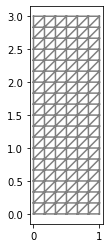

In [105]:
# Mallat uniforme
#mesh=RectangleMesh(Point(0, 0), Point(b, h), N, M)
#plot(mesh)
#plt.show()
N = 6
M=3*N
# Mallat no uniforme
mesh = RectangleMesh(Point(0, 0), Point(1, 3), N, M)

#Mallat no uniforme:
plot(mesh)
plt.show()
# Espai de funcions
V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió i la concentració

In [106]:
# Definim les condicions de contorn


def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

base_tapa  = 'near(x[1], 0) || near(x[1], 3)' 
base  = 'near(x[1], 0)' 
paret = 'near(x[0], 0) || near(x[0], 1)'

#velocitat
bcu_base_tapa  = DirichletBC(V, Constant((0, 0)), base_tapa)
bcu_paret  = DirichletBC(V, Constant((0, 0)), paret)
#pressió
patm = 101325
patm0 = patm/p_0
print(patm0)
bcp_base_tapa  = DirichletBC(Q, Constant(patm0) , base_tapa) 
bcp_paret  = DirichletBC(Q, Constant(patm0), paret) 
#concentració
bcc_base  = DirichletBC(Q, Constant(0), base)

bcu = [bcu_base_tapa, bcu_paret] 
bcp = []
bcc = [bcc_base]

24785.36473440705


In [107]:
# Define trial and test functions
#velocitat
u = TrialFunction(V)
v = TestFunction(V)
#pressió
p = TrialFunction(Q)
q = TestFunction(Q)
#concentració
c = TrialFunction(Q)
d = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)
c_n = Function(Q)
c_  = Function(Q)


In [108]:
# càlcul del gradB_max

y_0=0
delta_B=((Br*r**2)/2)*((pow((y_0+hi)**2+r**2,-3/2))-(pow(y_0**2+r**2,-3/2)))
print(delta_B)

-95.73878719713858


In [109]:
# Define expressions used in variational forms
p_n.assign(Constant(patm0))
u_n.assign(Constant([0,0]) )
c_n.assign(Constant(1))


dyB = Expression(('((1.45*0.007*0.007)/2)*((pow((x[1]*0.01+1.5)*(x[1]*0.01+1.5)+0.007*0.007,-3/2))-(pow(x[1]*x[1]*0.01*0.01+0.007*0.007,-3/2)))/95.74'), degree=2)
M   = Constant([0,1])
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f = c_n*M*dyB

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return epsilon(u)/Re - p*Identity(len(u))

In [110]:
# Define variational problem for step 1
F1 = dot((u - u_n) / k, v)*dx + \
     dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Concentració
F4 = dot((c-c_n)/k,d)*dx+dot(kct*c,d)*dx
a4 = lhs(F4)
L4 = rhs(F4)

In [111]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)
A4 = assemble(a4)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
[bc.apply(A3) for bc in bcu]
[bc.apply(A4) for bc in bcc]

[None]

Solució per t=10 s


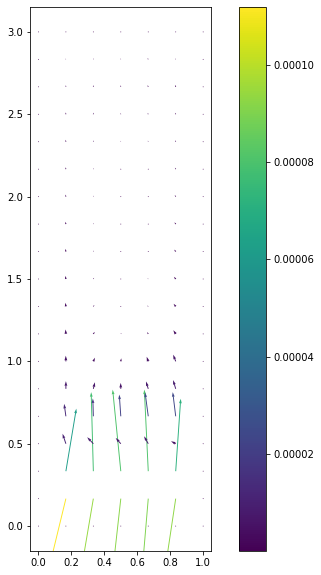

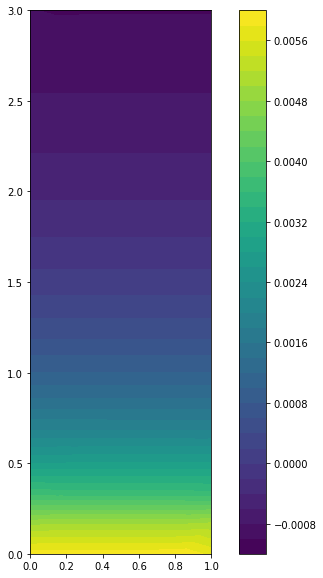

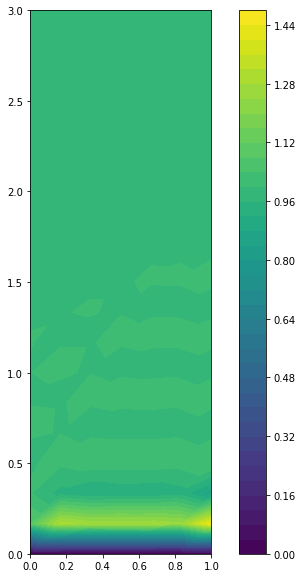

Solució per t=450 s


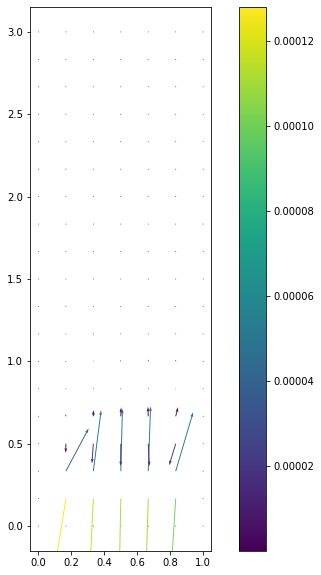

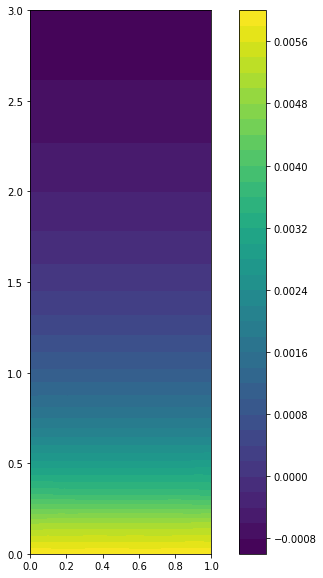

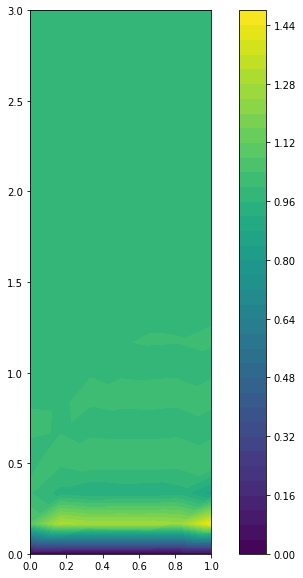

In [112]:

eix_x = np.linspace(0, 1, 3)
u_05=[]
e0 = [0,0,0]
u_t = []
c_t = []
# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)
    
    # Step 4: Concentració
    b4 = assemble(L4)
    [bc.apply(b4) for bc in bcc]
    solve(A4, c_.vector(), b4)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    c_n.assign(c_)
    
    if t==10:
        print("Solució per t=10 s")
        plt.figure(figsize=(10,10))

        e=plot(u_)
        plt.colorbar(e)
        plt.show()
        
        plt.figure(figsize=(10,10))
        e=plot(p_)
        plt.colorbar(e)
        plt.show()
        
        plt.figure(figsize=(10,10))
        e=plot(c_)
        plt.colorbar(e)
        plt.show()
    
    if t==500:
        print("Solució per t=450 s")
        plt.figure(figsize=(10,10))

        e=plot(u_)
        plt.colorbar(e)
        plt.show()
        
        plt.figure(figsize=(10,10))
        e=plot(p_)
        plt.colorbar(e)
        plt.show()
        
        plt.figure(figsize=(10,10))
        e=plot(c_)
        plt.colorbar(e)
        plt.show()

    
    cmean = float(np.array(c_.vector()).mean())
    c_t.append(cmean)
    for i, x in enumerate(eix_x):
        u_05.append(e0)
        u_05[i] = u_(x,0.1)
    modul = np.linalg.norm(u_05[1])
    u_t.append(modul)





Solució per t=900s normalitzada


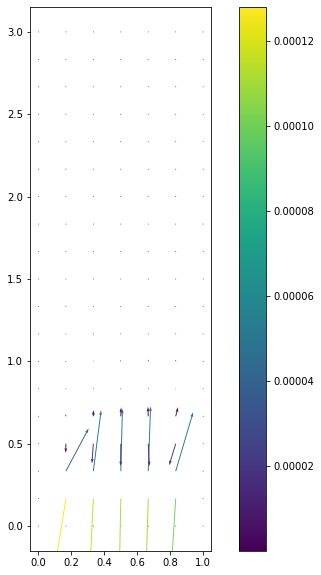

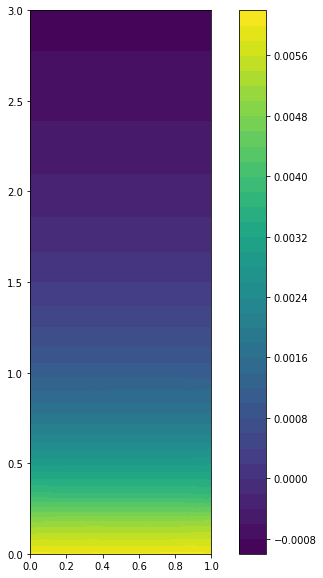

In [113]:
# Solució "normalitzada" 
plt.figure(figsize=(10,10))
print("Solució per t=900s normalitzada")
cu=plot(u_n)
plt.colorbar(cu)
plt.show()

plt.figure(figsize=(10,10))
cp=plot(p_n)
plt.colorbar(cp)
plt.show()

Solució per t=900s sense normalitzar


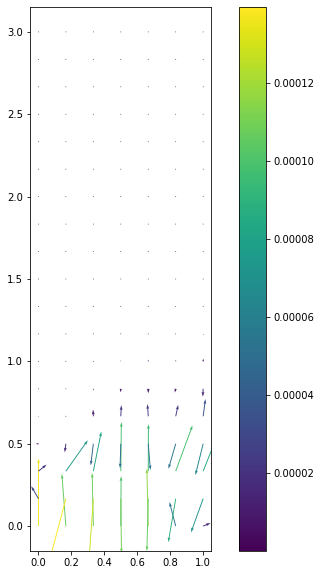

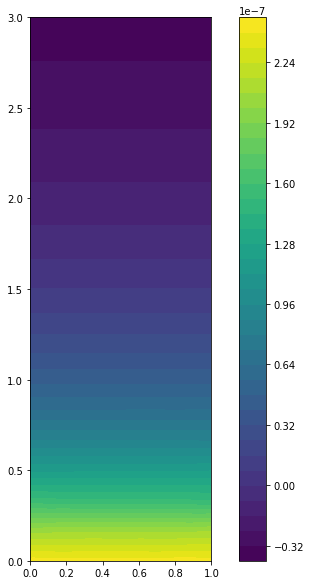

In [114]:
# Solució sense adimensionalitzar
u_d= u_*u0
p_d=project(p0*p_)
print("Solució per t=900s sense normalitzar")
#concentració
plt.figure(figsize=(10,10))
g=plot(u_d)
plt.colorbar(g)
plt.show()

#pressió/patm
plt.figure(figsize=(10,10))
p_datm = p_d/patm
e_=plot(p_datm)
plt.colorbar(e_)
plt.show()

Velocitat u(x) per y=0.001m
[ -3.07201404e-09   5.73037831e-09]
[ -1.17439043e-06  -9.94224225e-08]
[ -3.99466484e-07   2.96438235e-07]
[ -3.81129914e-08   5.70408801e-07]
[ -1.18730907e-07   6.76411812e-07]
[ -1.22002322e-06   6.90648163e-07]
[ -4.92062673e-10  -5.23946702e-10]


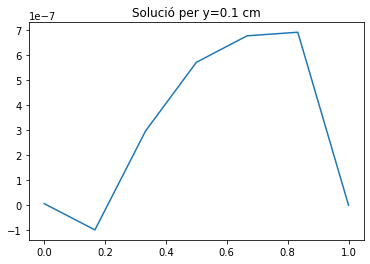

In [132]:
# fem el mateix amb la velocitat per y=0.1
print("Velocitat u(x) per y=0.001m")
eix_x = np.linspace(0, 1, N+1)
e0 = [0,0,0]
u_y_01=[]
ey = [0,1]
u_y01 = []

for i, x in enumerate(eix_x):
    a = 0
    a = u_(x,0.1)*c_0
    print(a)
    u_y01.append(a[1])
    

    
plt.plot(eix_x, u_y01, label= 'Solució numèrica')
plt.title("Solució per y=0.1 cm")
plt.show()

Velocitat u(x) per y=0.005m


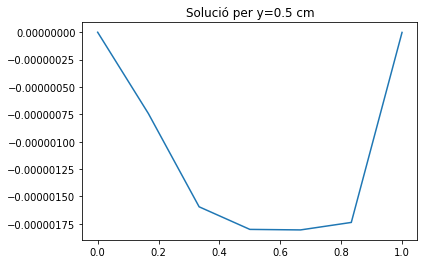

In [137]:
# fem el mateix amb la velocitat per y=0.5
print("Velocitat u(x) per y=0.005m")
eix_x = np.linspace(0, 1, N+1)
e0 = [0,0,0]
u_y_01=[]
ey = [0,1]
u_y01 = []

for i, x in enumerate(eix_x):
    a = 0
    a = u_(x,0.5)*c_0
    u_y01.append(a[1])
    

    
plt.plot(eix_x, u_y01, label= 'Solució numèrica')
plt.title("Solució per y=0.5 cm")
plt.show()

Mòdul de la velocitat en el punt x=0.005m i y=0.001m


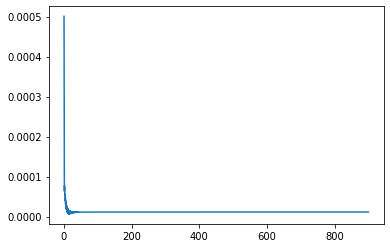

In [119]:
#Representem el modul de la velocitat en el punt (0.5,0.1) al llarg del temps
print("Mòdul de la velocitat en el punt x=0.005m i y=0.001m")
t=0
temps=[]
for i in range(num_steps):
    t += dt
    temps.append(t)
u_t=u_0*np.array(u_t)
plt.plot(temps, u_t, label= 'Solució numèrica')
  



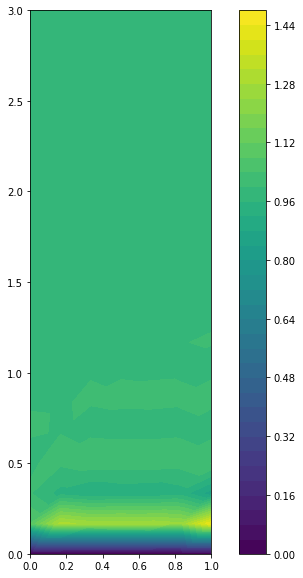

In [120]:
#concentració
plt.figure(figsize=(10,10))

e_c=plot(c_)
plt.colorbar(e_c)
plt.show()

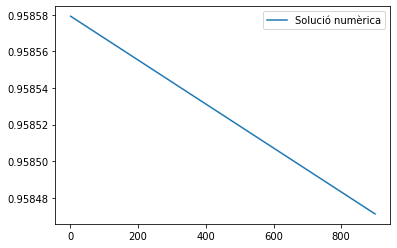

In [143]:
#Representem la concentració  al llarg del temps
e = 2.7182818284 
conc = []
t=0
temps=[]
for i in range(num_steps):
    b=0
    t += dt
    b = pow(e,-kc_*t)
    temps.append(t)
    conc.append(b)
plt.plot(temps, c_t, label= 'Solució numèrica')
#plt.plot(temps, conc, label= 'Solució analítica')
plt.legend()
plt.show()
